# Architecture Diagrams: FNN Cone, GRU, OLS Regression

Visual representations of the three deep hedging models used in the MSc thesis.

- **FNN**: Cone architecture (narrowing hidden layers), CELU activations, 1 output → sigmoid allocation
- **GRU**: Pre-MLP → stacked GRU → head MLP, d_traded=2 outputs → direct hedge positions
- **OLS Regression**: Closed-form linear model, d_traded=2 outputs → direct hedge positions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

## 1. FNN Cone Hedger

Narrowing "cone" feedforward network. At each time step $k$, maps features $X_k \in \mathbb{R}^8$ (log-prices, time-to-maturity, signatures) to a **single** logit $h_k$. Portfolio allocation via $w_1 = \sigma(h_k)$, $w_2 = 1 - w_1$.

**Architecture**: `start_width → start_width//2 → ... → 4 → 1`  
**Block**: Linear → LayerNorm → CELU → Dropout  
**Output head**: Linear(last_width, 1) — identity (no activation)

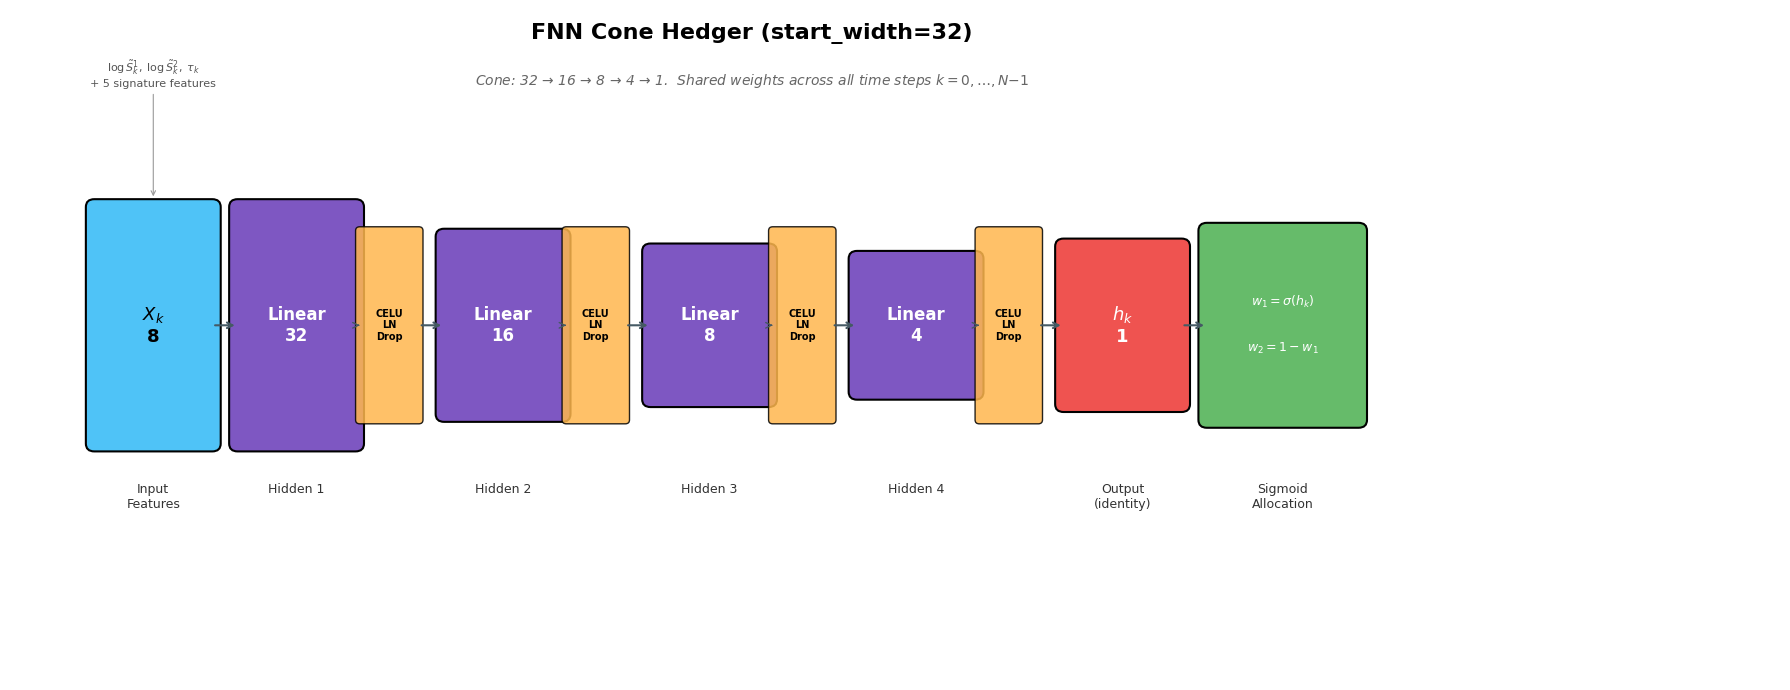

In [2]:
def draw_fnn_cone(save_path=None, start_width=32):
    """Draw the FNN Cone hedger architecture diagram.
    
    Cone: start_width -> halving -> min 4.
    Example with start_width=32: [32, 16, 8, 4]
    """
    # Compute cone widths
    widths = []
    w = start_width
    while w >= 4:
        widths.append(w)
        w = w // 2

    fig, ax = plt.subplots(figsize=(18, 7))
    ax.set_xlim(-1, 4 + (len(widths) + 1) * 2.8 + 2)
    ax.set_ylim(-3, 5.5)
    ax.axis('off')

    # Colour palette
    c_input = '#4FC3F7'    # light blue
    c_hidden = '#7E57C2'   # purple
    c_output = '#EF5350'   # red
    c_act = '#FFB74D'      # orange
    c_arrow = '#455A64'    # dark grey
    c_sigmoid = '#66BB6A'  # green

    box_h = 3.0
    box_w = 1.4
    act_w = 0.7
    gap = 0.3

    # --- Input block ---
    x = 0
    inp = FancyBboxPatch((x, 0), box_w, box_h, boxstyle='round,pad=0.1',
                         facecolor=c_input, edgecolor='black', linewidth=1.5)
    ax.add_patch(inp)
    ax.text(x + box_w/2, box_h/2, '$X_k$\n8', ha='center', va='center',
            fontsize=13, fontweight='bold')
    ax.text(x + box_w/2, -0.5, 'Input\nFeatures', ha='center', va='top', fontsize=9, color='#333')

    # Feature breakdown annotation
    ax.annotate('$\\log \\tilde{S}_k^1,\\; \\log \\tilde{S}_k^2,\\; \\tau_k$\n+ 5 signature features',
                xy=(x + box_w/2, box_h + 0.1), xytext=(x + box_w/2, box_h + 1.5),
                ha='center', va='bottom', fontsize=8, color='#555',
                arrowprops=dict(arrowstyle='->', color='#999', lw=0.8))

    prev_x = x + box_w

    # --- Hidden blocks (cone) ---
    for i, width in enumerate(widths):
        # Arrow
        ax.annotate('', xy=(prev_x + gap, box_h/2), xytext=(prev_x, box_h/2),
                    arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))

        # Scale box height to visualize narrowing
        scale = width / widths[0]
        bh = box_h * (0.5 + 0.5 * scale)
        by = (box_h - bh) / 2

        # Linear block
        x = prev_x + gap
        hid = FancyBboxPatch((x, by), box_w, bh, boxstyle='round,pad=0.1',
                             facecolor=c_hidden, edgecolor='black', linewidth=1.5)
        ax.add_patch(hid)
        ax.text(x + box_w/2, box_h/2, f'Linear\n{width}', ha='center', va='center',
                fontsize=12, fontweight='bold', color='white')
        ax.text(x + box_w/2, -0.5, f'Hidden {i+1}', ha='center', va='top', fontsize=9, color='#333')

        # Activation sub-block (CELU + LN + Dropout)
        ax2 = x + box_w
        ax.annotate('', xy=(ax2 + 0.05, box_h/2), xytext=(ax2, box_h/2),
                    arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.0))
        act = FancyBboxPatch((ax2 + 0.05, 0.3), act_w, box_h - 0.6,
                             boxstyle='round,pad=0.05',
                             facecolor=c_act, edgecolor='black', linewidth=1.0, alpha=0.85)
        ax.add_patch(act)
        ax.text(ax2 + 0.05 + act_w/2, box_h/2, 'CELU\nLN\nDrop', ha='center', va='center',
                fontsize=7, fontweight='bold')

        prev_x = ax2 + 0.05 + act_w

    # --- Output head block ---
    ax.annotate('', xy=(prev_x + gap, box_h/2), xytext=(prev_x, box_h/2),
                arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))
    x = prev_x + gap
    out = FancyBboxPatch((x, 0.5), box_w, box_h - 1.0, boxstyle='round,pad=0.1',
                         facecolor=c_output, edgecolor='black', linewidth=1.5)
    ax.add_patch(out)
    ax.text(x + box_w/2, box_h/2, '$h_k$\n1', ha='center', va='center',
            fontsize=13, fontweight='bold', color='white')
    ax.text(x + box_w/2, -0.5, 'Output\n(identity)', ha='center', va='top', fontsize=9, color='#333')

    # --- Sigmoid allocation box ---
    prev_x = x + box_w
    ax.annotate('', xy=(prev_x + gap, box_h/2), xytext=(prev_x, box_h/2),
                arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))
    x = prev_x + gap
    sig = FancyBboxPatch((x, 0.3), box_w + 0.4, box_h - 0.6, boxstyle='round,pad=0.1',
                         facecolor=c_sigmoid, edgecolor='black', linewidth=1.5)
    ax.add_patch(sig)
    ax.text(x + (box_w + 0.4)/2, box_h/2 + 0.3,
            '$w_1 = \\sigma(h_k)$', ha='center', va='center',
            fontsize=9, fontweight='bold', color='white')
    ax.text(x + (box_w + 0.4)/2, box_h/2 - 0.3,
            '$w_2 = 1 - w_1$', ha='center', va='center',
            fontsize=9, fontweight='bold', color='white')
    ax.text(x + (box_w + 0.4)/2, -0.5, 'Sigmoid\nAllocation', ha='center', va='top',
            fontsize=9, color='#333')

    # Title
    total_w = x + box_w + 1
    mid = total_w / 2
    ax.text(mid, 5.2, f'FNN Cone Hedger (start_width={start_width})',
            ha='center', va='center', fontsize=16, fontweight='bold')
    widths_str = ' → '.join(str(w) for w in widths) + ' → 1'
    ax.text(mid, 4.6,
            f'Cone: {widths_str}.  Shared weights across all time steps $k = 0, \\ldots, N{{-}}1$',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_fnn_cone('Figures/fnn_cone_architecture.png', start_width=32)

## 2. GRU Hedger

Pre-MLP $\to$ stacked GRU $\to$ Head MLP. Processes the feature sequence causally and outputs **direct hedge positions** $h_k \in \mathbb{R}^2$ at each step. Gains: $g_k = h_k \odot \Delta S_k$.

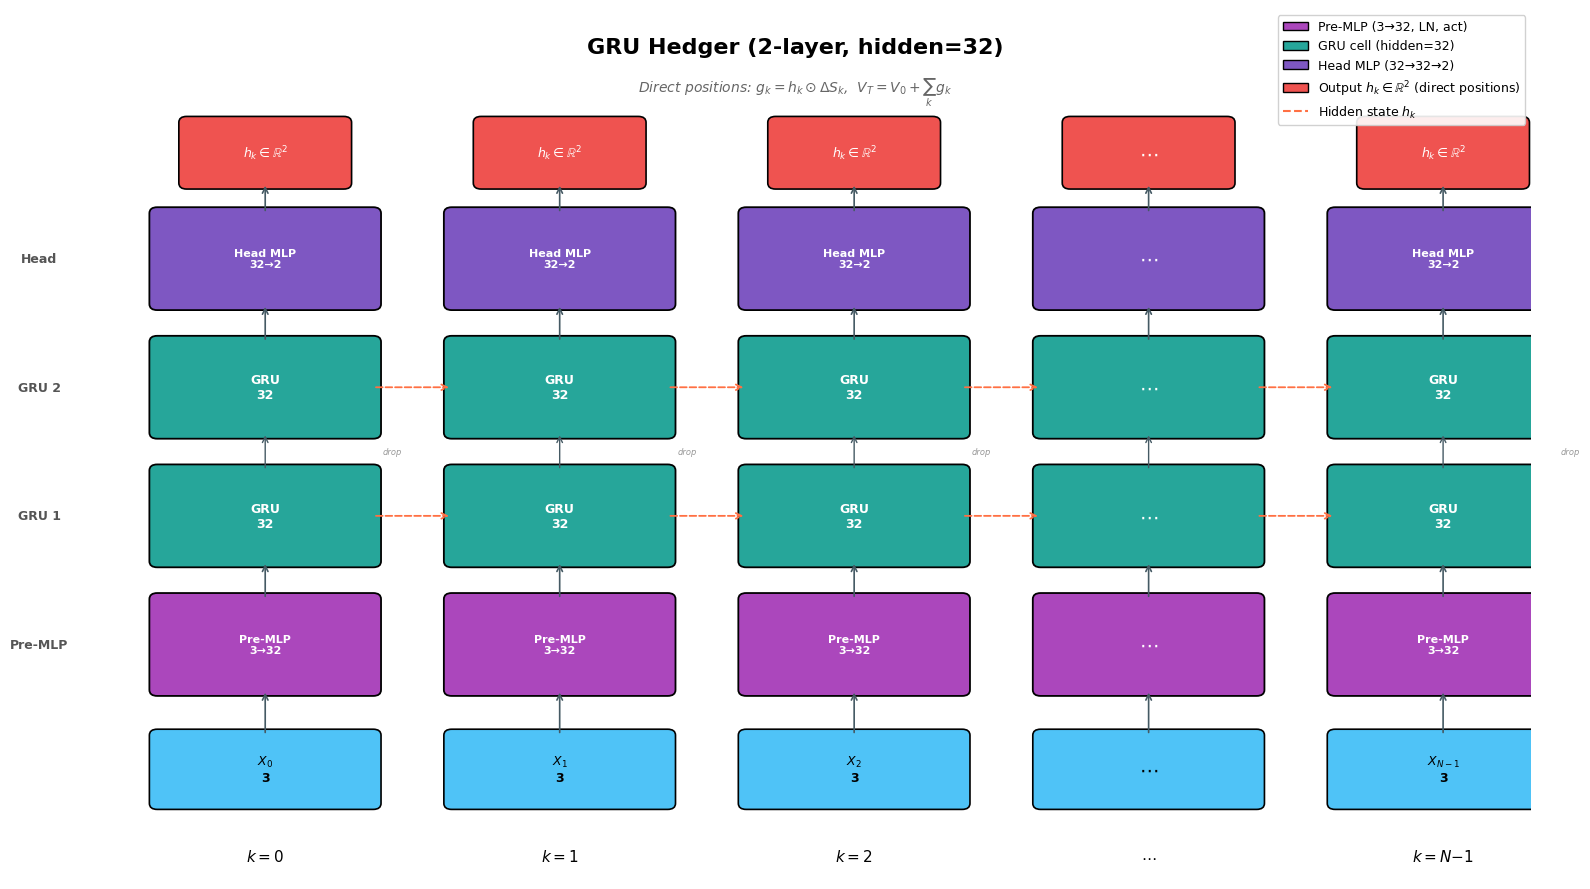

In [3]:
def draw_gru(save_path=None, num_layers=2, hidden_size=32):
    """Draw the GRU hedger architecture diagram.
    
    Pre-MLP(3 -> hidden) -> stacked GRU(hidden, num_layers) -> Head MLP(hidden -> 2)
    """
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_xlim(-1.5, 14)
    ax.set_ylim(-2.5, 9)
    ax.axis('off')

    # Colours
    c_input = '#4FC3F7'    # light blue
    c_premlp = '#AB47BC'   # purple for pre-MLP
    c_gru = '#26A69A'      # teal
    c_head = '#7E57C2'     # deeper purple for head MLP
    c_output = '#EF5350'   # red
    c_arrow = '#455A64'
    c_recur = '#FF7043'    # deep orange for recurrent

    cell_w = 2.2
    cell_h = 1.2
    v_gap = 0.5

    # Time steps (columns)
    time_labels = ['$k=0$', '$k=1$', '$k=2$', r'$\cdots$', '$k=N{-}1$']
    input_labels = ['$X_0$\n3', '$X_1$\n3', '$X_2$\n3', r'$\cdots$', '$X_{N-1}$\n3']
    n_cols = len(time_labels)
    col_xs = [i * 3.0 for i in range(n_cols)]

    # Vertical layers: Pre-MLP (1) + GRU layers (num_layers) + Head MLP (1)
    # y positions: Pre-MLP at bottom, then GRU layers, then Head at top
    pre_y = 0.0
    gru_ys = [pre_y + cell_h + v_gap + i * (cell_h + v_gap) for i in range(num_layers)]
    head_y = gru_ys[-1] + cell_h + v_gap

    for col_idx, (cx, t_label) in enumerate(zip(col_xs, time_labels)):
        is_dots = (col_idx == 3)

        # Input at bottom
        inp_y = -1.5
        inp = FancyBboxPatch((cx, inp_y), cell_w, 0.9, boxstyle='round,pad=0.08',
                             facecolor=c_input, edgecolor='black', linewidth=1.2)
        ax.add_patch(inp)
        lbl = r'$\cdots$' if is_dots else input_labels[col_idx]
        ax.text(cx + cell_w/2, inp_y + 0.45, lbl,
                ha='center', va='center', fontsize=9 if not is_dots else 14, fontweight='bold')

        # Arrow from input to Pre-MLP
        ax.annotate('', xy=(cx + cell_w/2, pre_y),
                    xytext=(cx + cell_w/2, inp_y + 0.9),
                    arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.2))

        # Pre-MLP
        pre = FancyBboxPatch((cx, pre_y), cell_w, cell_h, boxstyle='round,pad=0.08',
                             facecolor=c_premlp, edgecolor='black', linewidth=1.3)
        ax.add_patch(pre)
        pre_lbl = r'$\cdots$' if is_dots else f'Pre-MLP\n3→{hidden_size}'
        ax.text(cx + cell_w/2, pre_y + cell_h/2, pre_lbl,
                ha='center', va='center', fontsize=8 if not is_dots else 14,
                color='white', fontweight='bold')

        # Arrow Pre-MLP to first GRU
        ax.annotate('', xy=(cx + cell_w/2, gru_ys[0]),
                    xytext=(cx + cell_w/2, pre_y + cell_h),
                    arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.2))

        # GRU layers
        for layer_idx in range(num_layers):
            gy = gru_ys[layer_idx]
            cell = FancyBboxPatch((cx, gy), cell_w, cell_h, boxstyle='round,pad=0.08',
                                  facecolor=c_gru, edgecolor='black', linewidth=1.3)
            ax.add_patch(cell)
            g_lbl = r'$\cdots$' if is_dots else f'GRU\n{hidden_size}'
            ax.text(cx + cell_w/2, gy + cell_h/2, g_lbl,
                    ha='center', va='center', fontsize=9 if not is_dots else 14,
                    color='white', fontweight='bold')

            # Vertical arrow to next layer
            if layer_idx < num_layers - 1:
                mid_y = gy + cell_h + v_gap * 0.5
                ax.annotate('', xy=(cx + cell_w/2, gru_ys[layer_idx + 1]),
                            xytext=(cx + cell_w/2, gy + cell_h),
                            arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.0))
                if not is_dots:
                    ax.text(cx + cell_w + 0.1, mid_y, 'drop', fontsize=6, color='#999',
                            va='center', style='italic')

            # Horizontal recurrent arrow to next time step
            if col_idx < n_cols - 1:
                next_cx = col_xs[col_idx + 1]
                ax.annotate('',
                            xy=(next_cx, gy + cell_h/2),
                            xytext=(cx + cell_w, gy + cell_h/2),
                            arrowprops=dict(arrowstyle='->', color=c_recur,
                                            lw=1.3, linestyle='--'))

        # Arrow from last GRU to Head MLP
        ax.annotate('', xy=(cx + cell_w/2, head_y),
                    xytext=(cx + cell_w/2, gru_ys[-1] + cell_h),
                    arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.2))

        # Head MLP
        hd = FancyBboxPatch((cx, head_y), cell_w, cell_h, boxstyle='round,pad=0.08',
                             facecolor=c_head, edgecolor='black', linewidth=1.3)
        ax.add_patch(hd)
        hd_lbl = r'$\cdots$' if is_dots else f'Head MLP\n{hidden_size}→2'
        ax.text(cx + cell_w/2, head_y + cell_h/2, hd_lbl,
                ha='center', va='center', fontsize=8 if not is_dots else 14,
                color='white', fontweight='bold')

        # Arrow to output
        out_y = head_y + cell_h + 0.4
        ax.annotate('', xy=(cx + cell_w/2, out_y),
                    xytext=(cx + cell_w/2, head_y + cell_h),
                    arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.2))

        # Output
        out = FancyBboxPatch((cx + 0.3, out_y), cell_w - 0.6, 0.8, boxstyle='round,pad=0.08',
                             facecolor=c_output, edgecolor='black', linewidth=1.2)
        ax.add_patch(out)
        o_lbl = r'$\cdots$' if is_dots else '$h_k \\in \\mathbb{R}^2$'
        ax.text(cx + cell_w/2, out_y + 0.4, o_lbl,
                ha='center', va='center', fontsize=9 if not is_dots else 14,
                color='white', fontweight='bold')

        # Time label
        ax.text(cx + cell_w/2, -2.2, t_label, ha='center', va='center', fontsize=11)

    # Layer labels on the left
    ax.text(-1.2, pre_y + cell_h/2, 'Pre-MLP', ha='center', va='center',
            fontsize=9, color='#555', fontweight='bold')
    for i in range(num_layers):
        ax.text(-1.2, gru_ys[i] + cell_h/2, f'GRU {i+1}', ha='center', va='center',
                fontsize=9, color='#555', fontweight='bold')
    ax.text(-1.2, head_y + cell_h/2, 'Head', ha='center', va='center',
            fontsize=9, color='#555', fontweight='bold')

    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        mpatches.Patch(facecolor=c_premlp, edgecolor='black', label=f'Pre-MLP (3→{hidden_size}, LN, act)'),
        mpatches.Patch(facecolor=c_gru, edgecolor='black', label=f'GRU cell (hidden={hidden_size})'),
        mpatches.Patch(facecolor=c_head, edgecolor='black', label=f'Head MLP ({hidden_size}→{hidden_size}→2)'),
        mpatches.Patch(facecolor=c_output, edgecolor='black', label='Output $h_k \\in \\mathbb{R}^2$ (direct positions)'),
        Line2D([0], [0], color=c_recur, lw=1.5, linestyle='--', label='Hidden state $h_k$'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.9)

    top = out_y + 1.8
    ax.text(6.5, top, f'GRU Hedger ({num_layers}-layer, hidden={hidden_size})',
            ha='center', va='center', fontsize=16, fontweight='bold')
    ax.text(6.5, top - 0.6,
            'Direct positions: $g_k = h_k \\odot \\Delta S_k$,  '
            '$V_T = V_0 + \\sum_k g_k$',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_gru('Figures/gru_architecture.png', num_layers=2, hidden_size=32)

## 3. OLS Regression Hedger

Closed-form linear model: $h_k = X_k \, \beta$ where $\beta = (X^\top X)^{-1} X^\top y$ is fit once on training data. Target $y$: per-asset Black-Scholes put delta (one delta per vol). Output: $h_k \in \mathbb{R}^2$ (direct hedge positions).

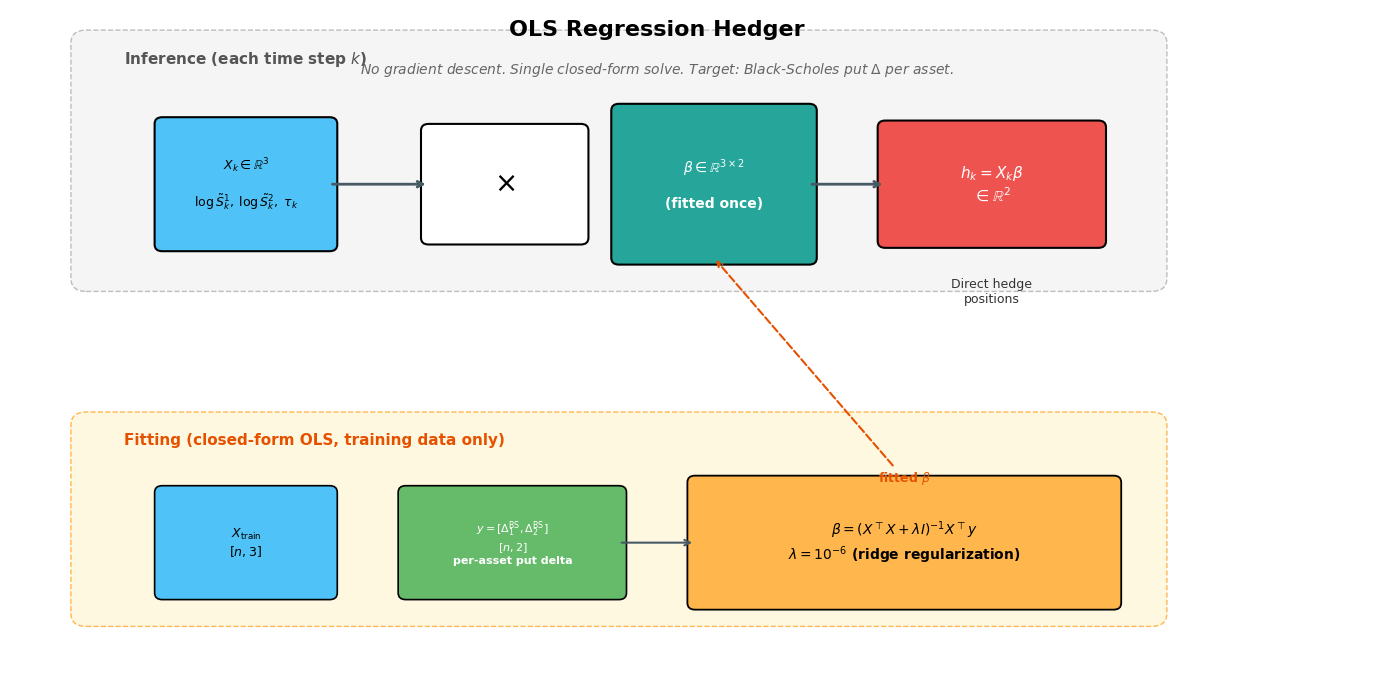

In [4]:
def draw_regression(save_path=None):
    """Draw the OLS Regression hedger architecture diagram."""
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.set_xlim(-2, 16)
    ax.set_ylim(-3, 7)
    ax.axis('off')

    # Colours
    c_input = '#4FC3F7'    # light blue
    c_beta = '#26A69A'     # teal for beta matrix
    c_output = '#EF5350'   # red
    c_target = '#66BB6A'   # green for BS delta target
    c_arrow = '#455A64'
    c_fit = '#FFB74D'      # orange for fitting stage
    c_bg = '#F5F5F5'

    # ===== Inference Path (top half) =====
    inf_y = 3.5

    # Background
    inf_bg = FancyBboxPatch((-1, inf_y - 0.5), 14, 3.5, boxstyle='round,pad=0.2',
                            facecolor=c_bg, edgecolor='#BDBDBD', linewidth=1.0, linestyle='--')
    ax.add_patch(inf_bg)
    ax.text(-0.5, inf_y + 2.7, 'Inference (each time step $k$)',
            fontsize=11, fontweight='bold', color='#555')

    # Input features
    inp = FancyBboxPatch((0, inf_y), 2.2, 1.8, boxstyle='round,pad=0.1',
                         facecolor=c_input, edgecolor='black', linewidth=1.5)
    ax.add_patch(inp)
    ax.text(1.1, inf_y + 0.9, '$X_k \\in \\mathbb{R}^3$\n\n$\\log \\tilde{S}_k^1,\\; '
            '\\log \\tilde{S}_k^2,\\; \\tau_k$',
            ha='center', va='center', fontsize=9, fontweight='bold')

    # Arrow
    ax.annotate('', xy=(3.5, inf_y + 0.9), xytext=(2.2, inf_y + 0.9),
                arrowprops=dict(arrowstyle='->', color=c_arrow, lw=2))

    # Matrix multiply
    mm = FancyBboxPatch((3.5, inf_y + 0.1), 2.0, 1.6, boxstyle='round,pad=0.1',
                        facecolor='white', edgecolor='black', linewidth=1.5)
    ax.add_patch(mm)
    ax.text(4.5, inf_y + 0.9, '$\\times$', ha='center', va='center', fontsize=20, fontweight='bold')

    # Beta matrix
    beta = FancyBboxPatch((6.0, inf_y - 0.2), 2.5, 2.2, boxstyle='round,pad=0.1',
                          facecolor=c_beta, edgecolor='black', linewidth=1.5)
    ax.add_patch(beta)
    ax.text(7.25, inf_y + 0.9,
            '$\\beta \\in \\mathbb{R}^{3 \\times 2}$\n\n(fitted once)',
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    # Arrow
    ax.annotate('', xy=(9.5, inf_y + 0.9), xytext=(8.5, inf_y + 0.9),
                arrowprops=dict(arrowstyle='->', color=c_arrow, lw=2))

    # Output
    out = FancyBboxPatch((9.5, inf_y + 0.05), 2.8, 1.7, boxstyle='round,pad=0.1',
                         facecolor=c_output, edgecolor='black', linewidth=1.5)
    ax.add_patch(out)
    ax.text(10.9, inf_y + 0.9, '$h_k = X_k \\beta$\n$\\in \\mathbb{R}^2$',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    ax.text(10.9, inf_y - 0.5, 'Direct hedge\npositions',
            ha='center', va='top', fontsize=9, color='#333')

    # ===== Training/Fitting Path (bottom half) =====
    fit_y = -2.0

    fit_bg = FancyBboxPatch((-1, fit_y), 14, 2.8, boxstyle='round,pad=0.2',
                            facecolor='#FFF8E1', edgecolor='#FFB74D', linewidth=1.0, linestyle='--')
    ax.add_patch(fit_bg)
    ax.text(-0.5, fit_y + 2.5, 'Fitting (closed-form OLS, training data only)',
            fontsize=11, fontweight='bold', color='#E65100')

    # Training X
    tx = FancyBboxPatch((0, fit_y + 0.3), 2.2, 1.5, boxstyle='round,pad=0.1',
                        facecolor=c_input, edgecolor='black', linewidth=1.2)
    ax.add_patch(tx)
    ax.text(1.1, fit_y + 1.05, '$X_{\\mathrm{train}}$\n$[n, 3]$',
            ha='center', va='center', fontsize=9, fontweight='bold')

    # Target y (BS deltas)
    ty = FancyBboxPatch((3.2, fit_y + 0.3), 2.8, 1.5, boxstyle='round,pad=0.1',
                        facecolor=c_target, edgecolor='black', linewidth=1.2)
    ax.add_patch(ty)
    ax.text(4.6, fit_y + 1.05,
            '$y = [\\Delta^{\\mathrm{BS}}_1, \\Delta^{\\mathrm{BS}}_2]$\n$[n, 2]$\nper-asset put delta',
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

    # Arrow to OLS formula
    ax.annotate('', xy=(7.0, fit_y + 1.05), xytext=(6.0, fit_y + 1.05),
                arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))

    # OLS formula box
    ols = FancyBboxPatch((7.0, fit_y + 0.15), 5.5, 1.8, boxstyle='round,pad=0.1',
                         facecolor=c_fit, edgecolor='black', linewidth=1.3)
    ax.add_patch(ols)
    ax.text(9.75, fit_y + 1.05,
            '$\\beta = (X^\\top X + \\lambda I)^{-1} X^\\top y$\n'
            '$\\lambda = 10^{-6}$ (ridge regularization)',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # Arrow from OLS to beta
    ax.annotate('fitted $\\beta$', xy=(7.25, inf_y - 0.2), xytext=(9.75, fit_y + 1.95),
                fontsize=9, color='#E65100', ha='center', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#E65100', lw=1.5, linestyle='--'))

    # Title
    ax.text(6.5, 6.7, 'OLS Regression Hedger', ha='center', va='center',
            fontsize=16, fontweight='bold')
    ax.text(6.5, 6.1,
            'No gradient descent. Single closed-form solve. '
            'Target: Black-Scholes put $\\Delta$ per asset.',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_regression('Figures/regression_architecture.png')

## 4. Side-by-Side Comparison

Summary of the three hedging models used in this thesis.

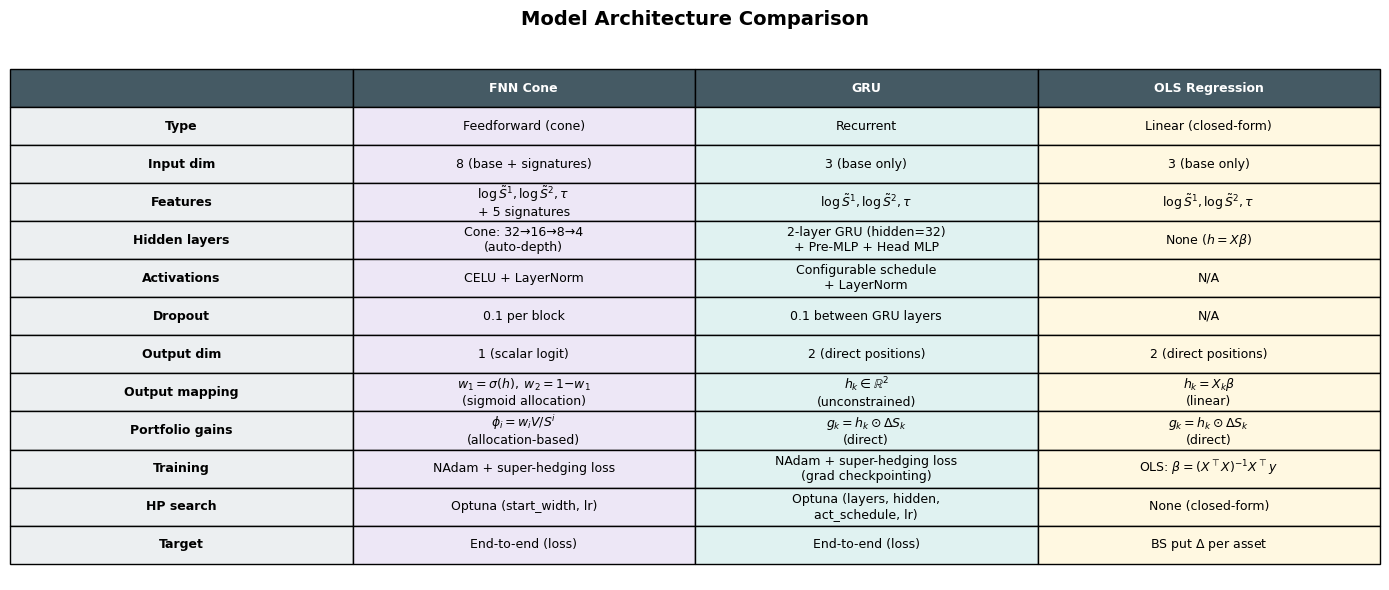

In [5]:
def draw_comparison_table(save_path=None):
    """Summary comparison figure of all three architectures."""
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')

    headers = ['', 'FNN Cone', 'GRU', 'OLS Regression']
    rows = [
        ['Type', 'Feedforward (cone)', 'Recurrent', 'Linear (closed-form)'],
        ['Input dim', '8 (base + signatures)', '3 (base only)', '3 (base only)'],
        ['Features', '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$\n+ 5 signatures',
         '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$',
         '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$'],
        ['Hidden layers', 'Cone: 32→16→8→4\n(auto-depth)', '2-layer GRU (hidden=32)\n+ Pre-MLP + Head MLP',
         'None ($h = X\\beta$)'],
        ['Activations', 'CELU + LayerNorm', 'Configurable schedule\n+ LayerNorm', 'N/A'],
        ['Dropout', '0.1 per block', '0.1 between GRU layers', 'N/A'],
        ['Output dim', '1 (scalar logit)', '2 (direct positions)', '2 (direct positions)'],
        ['Output mapping', '$w_1 = \\sigma(h),\\; w_2 = 1{-}w_1$\n(sigmoid allocation)',
         '$h_k \\in \\mathbb{R}^2$\n(unconstrained)', '$h_k = X_k \\beta$\n(linear)'],
        ['Portfolio gains', '$\\phi_i = w_i V / S^i$\n(allocation-based)',
         '$g_k = h_k \\odot \\Delta S_k$\n(direct)', '$g_k = h_k \\odot \\Delta S_k$\n(direct)'],
        ['Training', 'NAdam + super-hedging loss', 'NAdam + super-hedging loss\n(grad checkpointing)',
         'OLS: $\\beta = (X^\\top X)^{-1}X^\\top y$'],
        ['HP search', 'Optuna (start_width, lr)', 'Optuna (layers, hidden,\nact_schedule, lr)',
         'None (closed-form)'],
        ['Target', 'End-to-end (loss)', 'End-to-end (loss)', 'BS put $\\Delta$ per asset'],
    ]

    table = ax.table(
        cellText=rows,
        colLabels=headers,
        loc='center',
        cellLoc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 2.0)

    # Style header
    for j in range(len(headers)):
        cell = table[0, j]
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#455A64')

    # Column colours (light tints)
    col_colours = {1: '#EDE7F6', 2: '#E0F2F1', 3: '#FFF8E1'}  # purple, teal, amber tints

    # Style row labels and cells
    for i in range(1, len(rows) + 1):
        cell = table[i, 0]
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor('#ECEFF1')
        for j in range(1, len(headers)):
            cell = table[i, j]
            cell.set_facecolor(col_colours.get(j, '#FFFFFF'))

    ax.set_title('Model Architecture Comparison', fontsize=14, fontweight='bold', pad=20)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_comparison_table('Figures/model_comparison_table.png')